In [1]:
%matplotlib inline
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import display
import ipywidgets as widgets

import vivarium.test_util as vtu

from vivarium.framework.event import listens_for
from vivarium.framework.population import uses_columns

In [2]:
np.random.seed(12345)  # set random seed for reproducibility

n_simulants = 100
n_days = 1000
t_timestep = 1 # days
t_start = pd.Timestamp('1990-01-01')

# Boids micromechanism

Each agent is a bird.  It has a position and a velocity, and has three rules, taken from http://www.kfish.org/boids/pseudocode.html

In [3]:
@listens_for('initialize_simulants', priority=0)
@uses_columns(['age', 'sex', 'x', 'y', 'vx', 'vy'])
def my_generate_base_population(event):
    """ Base population needs nothing, really
    
    updates columns age and sex because CEAM expects them
    """
    population = pd.DataFrame(index=event.index)
    population['age'] = 0
    population['sex'] = '-'
    
    population['x'] = np.random.uniform(size=len(population))
    population['y'] = np.random.uniform(size=len(population))

    population['vx'] = .1*np.random.uniform(size=len(population))
    population['vy'] = .1*np.random.uniform(size=len(population))
    
    # update the population in the model
    event.population_view.update(population)


# instead of using simulate, just do this:
components = [my_generate_base_population]
simulation = vtu.setup_simulation(components, population_size=n_simulants, start=t_start)
vtu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

1000

In [4]:
def d(t, i, j):
    dx = t.x[i] - t.x[j]
    dy = t.y[i] - t.y[j]
    return dx*dx + dy*dy


class Boids:
    def __init__(self, center_pull_weight, closeness, velocity_match, noise):
        self.center_pull_weight = center_pull_weight
        self.closeness = closeness
        self.velocity_match = velocity_match
        self.noise = noise
        self.boid_x = []
        self.boid_y = []
        
    def rule1(self, t):
        """Rule 1: Boids try to fly towards the centre of mass of neighbouring boids.
        """
        # center of mass
        cx, cy = t.x.mean(), t.y.mean()
    
        return self.center_pull_weight*(cx - t.x), self.center_pull_weight*(cy - t.y) 

    def rule2(self, t):
        """Rule 2: Boids try to keep a small distance away from other objects (including other boids).
        """
        #     dvx = np.zeros_like(t.vx)
        #     dvy = np.zeros_like(t.vy)

        #     for i in range(len(t)):
        #         for j in range(i+1, len(t)):
        #             if d(t, i, j) < .1:
        #                 dvx[i] -= (t.x[j] - t.x[i])
        #                 dvy[i] -= (t.y[j] - t.y[i])

        # the above seems slow, let's just stay away from center of mass
        cx, cy = t.x.mean(), t.y.mean()
        dx = (t.x - cx)
        dy = (t.y - cy)
    
        close = dx*dx + dy*dy < self.closeness
        dvx = np.where(close, t.x - cx, 0)
        dvy = np.where(close, t.y - cy, 0)
    
        return dvx, dvy

    def rule3(self, t):
        """Rule 3: Boids try to match velocity with near boids.
        """
        # mean velocity
        mvx, mvy = t.vx.mean(), t.vy.mean()
    
        return self.velocity_match*(mvx - t.vx), self.velocity_match*(mvy - t.vy) 
    
    def rule4(self, t):
        return self.noise*np.random.uniform(low=-1, high=1, size=len(t)), self.noise*np.random.uniform(low=-1, high=1, size=len(t))

    @listens_for('time_step')
    @uses_columns(['x', 'y', 'vx', 'vy'])
    def move_all_boids(self, event):
        t = event.population
        v1x, v1y = self.rule1(t)
        v2x, v2y = self.rule2(t)
        v3x, v3y = self.rule3(t)
        v4x, v4y = self.rule4(t)

        t.vx += v1x + v2x + v3x
        t.vy += v1y + v2y + v3y

        t.x = (t.x + .1*t.vx)
        t.y = (t.y + .1*t.vy)
    
        event.population_view.update(t)
    
        self.boid_x.append(t.x % 1)
        self.boid_y.append(t.y % 1)

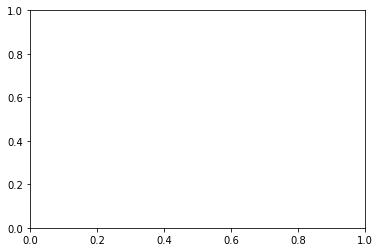

VBox(children=(FloatSlider(value=0.1, description='center_pull_weight', max=1.0), FloatSlider(value=0.1, description='closeness', max=1.0), FloatSlider(value=0.1, description='velocity match', max=1.0), FloatSlider(value=0.1, description='noise', max=1.0), Button(description='Save Gif', style=ButtonStyle()), Button(description='Update Display', style=ButtonStyle())))

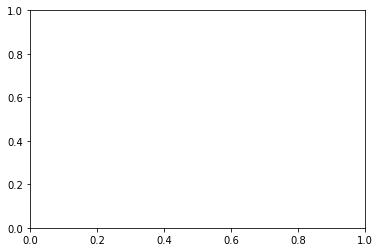

VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

In [6]:
current_boids = None

# First set up the figure, the axis, and the plot element we want to animate
plots = dict()
fig, ax = plt.subplots()
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
line, = ax.plot([], [], lw=2)
display(fig)

# initialization function: plot the background of each frame
def init():    
    line.set_data([], [])
    line.set_marker('o')
    line.set_linestyle('none')
    return (line,)

# animation function. This is called sequentially
def animate(i):
    t=99
    #x,y = np.array(boid_x)[:(t+1),i], np.array(boid_y)[:(t+1),i]    
    x,y = current_boids.boid_x[i], current_boids.boid_y[i]
    line.set_data(x, y)
    return (line,)



center_pull_weight = widgets.FloatSlider(description='center_pull_weight', value=0.1, min=0, max=1, step=0.1)
closeness = widgets.FloatSlider(description='closeness', value=0.1, min=0, max=1, step=0.1)
velocity_match = widgets.FloatSlider(description='velocity match', value=0.1, min=0, max=1, step=0.1)
noise = widgets.FloatSlider(description='noise', value=0.1, min=0, max=1, step=0.1)
save_button = widgets.Button(description="Save Gif")
display_button = widgets.Button(description="Update Display")
widget_container = widgets.VBox([center_pull_weight, closeness, velocity_match, noise, save_button, display_button])

display(widget_container)


def on_display_button_clicked(button):    
    current_boids = Boids(center_pull_weight.value, closeness.value, velocity_match.value, noise.value)
    components = [my_generate_base_population, current_boids]
    simulation = vtu.setup_simulation(components, population_size=n_simulants, start=t_start)
    vtu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))
    i=0
    t=99    
    #line.set_data(np.array(current_boids.boid_x)[:(t+1),i], np.array(current_boids.boid_y)[:(t+1),i])
    plots, = ax.plot(np.array(current_boids.boid_x)[:(t+1),i], np.array(current_boids.boid_y)[:(t+1),i], 'ks-')
    #plots, = ax.plot(current_boids.boid_x[0], current_boids.boid_y[0], 'o') 
    #plots, = ax.plot(current_boids.boid_x[t], current_boids.boid_y[t], 'o')
    display(plots)

    
def on_save_button_clicked(button):
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=n_days, blit=True)
    %time anim.save('animation.gif', writer='imagemagick', fps=60)


save_button.on_click(on_save_button_clicked)
display_button.on_click(on_display_button_clicked)



Figured out a workflow: save as gif with imagemagick, then load into notebook, or open in separate browser tab:

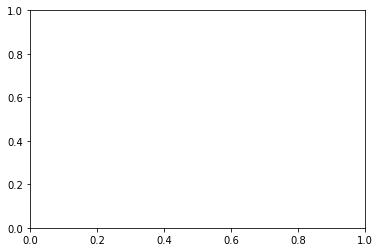

In [7]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 1))
ax.set_ylim((0, 1))

line, = ax.plot([], [], lw=2)

In [8]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line.set_marker('o')
    line.set_linestyle('none')
    return (line,)


In [9]:
# animation function. This is called sequentially
def animate(i):
    t=99

    #x,y = np.array(boid_x)[:(t+1),i], np.array(boid_y)[:(t+1),i]

    x,y = boid_x[i], boid_y[i]

    line.set_data(x, y)
    return (line,)


In [10]:
from matplotlib import animation, rc

In [11]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_days, blit=True)


In [12]:
%time anim.save('animation.gif', writer='imagemagick', fps=60)

NameError: name 'boid_x' is not defined